# Movie Recommendations using Collaborative Filtering
### - Dataset used: Group Lens 100K movie dataset

In [70]:
#Imports
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from scipy.optimize import fmin_cg

#CONSTANTS
"""Read data from files."""
DATAPATH = "/Users/debojitkaushik/collaborative-filtering/ml-100k/"
Y_cols  = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(DATAPATH + 'u.data', sep = '\t', encoding = 'latin-1', names = Y_cols).drop("timestamp", 1)
data

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
5,298,474,4
6,115,265,2
7,253,465,5
8,305,451,3
9,6,86,3


### - Preprocessing/Formatting
Create movies VS user matrix and ratings matrix. Create Y matrix and ratings matrix. Data is a dataframe with UserID|Movie_id|Rating format. Need to Vectorize this into a ratings matrix of MovieID vs UserID. Create the R matrix, which will have 1 if a user has rated or 0 if not.

In [81]:
# Unique values of Users and movies. nu and nm.
nm, nu = len(data['item_id'].unique()), len(data['user_id'].unique())
nf = 10

# Faster method of creating 2D matrix with user ratings
t = time.time()
Y = np.array(data.pivot(index = 'item_id', columns = 'user_id', values = 'rating').fillna((0.)))
ratings = (Y > 0.).astype(int)
print("Time to create Y and R: %0.4fs" %(time.time() - t))
print("Y:", Y.shape)
print("R:", ratings.shape)


# Initilize two matrices of size (nm, nu) and fill in the data.
# # **Slow method. Need to optimize this. Will look into Pandas methods more. 
# Y, ratings  = np.zeros((nm, nu)), np.zeros((nm, nu))
# t = time.time()
# for it, item in data.iterrows():
#     ratings[item['item_id']-1][item['user_id']-1] = 1.0
#     Y[item['item_id']-1][item['user_id']-1] = item['rating']
# print("Time to create matrices:", (time.time() - t))

#OPTIONAL DATA SOURCE:
# datafile = 'aux_data/ex8_movies.mat'
# mat = scipy.io.loadmat( datafile )
# Y = mat['Y']
# ratings = mat['R']

Time to create Y and R: 0.0705s
Y: (1682, 943)
R: (1682, 943)


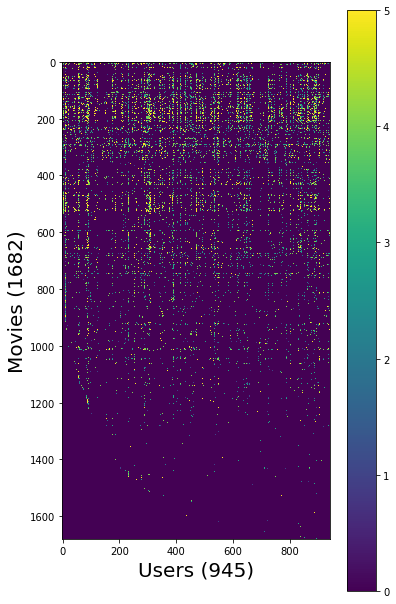

In [72]:
#Visualize the data matrix.
fig = plt.figure(figsize=(6,6*(nm/nu)))
dummy = plt.imshow(Y)
dummy = plt.colorbar()
dummy = plt.ylabel('Movies (%d)'%nm,fontsize=20)
dummy = plt.xlabel('Users (%d)'%nu,fontsize=20)
#We can see the sparseness of the matrix as it is dominated by 0 values.

### - Cost Function and Gradient definitions

In [82]:
#OPTIONAL: loading Theta and X matrices. 
# mat = scipy.io.loadmat("data/ex8_movieParams.mat")
# theta, X, nf = mat['Theta'], mat['X'], mat['num_features']

#Let's randomly initialize Theta and X matrices for starting points before we start learning.
X, Theta = np.random.rand(nm, nf), np.random.rand(nu, nf)
print("Shapes of Theta, X, Y, ratings:", [i.shape for i in [Theta, X, Y, ratings]])


Shapes of Theta, X, Y, ratings: [(943, 10), (1682, 10), (1682, 943), (1682, 943)]


In [84]:
'''Method to flatten theta and X matrices into one vector'''
def flatten_mat(X, Theta):
    try:
        return np.concatenate((X.flatten(), Theta.flatten()))
    except Exception as e:
        print(e)
        
'''Method to extract X and theta from the flattened matrix and reshape.'''
def unflatten(flattened_mat, mynu, mynm, mynf):
    #X dimensions: nm*nf, theta dimensions: nu*nf
    new_X = flattened_mat[:int(mynm*mynf)].reshape(mynm, mynf)
    new_theta = flattened_mat[int(mynm*mynf):].reshape(mynu, mynf)
    return new_X, new_theta

'''Compute cost function'''
def CFCost(params, myY, myR, mynu, mynm, mynf, myLambda = 0):
    '''
    args:
        params: X+Theta (flattened vector)
        myY: Movies VS Users matrix.
        nu, nm, nf: No of user, no of movies, no of features
    '''
    #Extract X and theta from params which is a merged vector.
    myX, myTheta = unflatten(params, mynu, mynm, mynf)
    
    #1/2∑((theta).T * X - Y)^2 + Regularization term
    term1 = myX.dot(myTheta.T)
    term1 = np.multiply(term1, myR)
    cost = 0.5 * np.sum(np.square(term1 - myY))
    
    #Regularization factors. Twice, for lambda and for X.
    #Regularizer: (λ/2) * (theta)^2 or (X)^2
    cost += (myLambda/2) * (np.sum(np.square(myTheta)))
    cost += (myLambda/2) * (np.sum(np.square(myX)))
    return cost

print("Test CF Cost:", CFCost(flatten_mat(X, Theta), Y, ratings, nu, nm, nf))

'''Gradient function. f'. '''
def CFCostGrad(params, myR, myY, mynu, mynm, mynf, myLambda = 0):
    '''
    args:
        params: X+Theta (flattened vector)
        myY: Movies VS Users matrix with their ratings.
        myR: Ratings binary matrix 0/1.
        nu, nm, nf: No of user, no of movies, no of features
    '''
    #This is the partial derivative of the cost function with respect
    #to theta and X.
    #Unroll params into Theta and X and proceed with the derivative 
    #calculation.
    myX, myTheta = unflatten(params, mynu, mynm, mynf)
    term1 = myX.dot(myTheta.T)
    term1 = np.multiply(term1, myR)
    term1 = term1 - myY
    X_grad = term1.dot(myTheta)
    theta_grad = term1.T.dot(myX)

    #Regularization
    X_grad += (myLambda * myX)
    theta_grad += (myLambda * myTheta)
    return flatten_mat(X_grad, theta_grad)

Test CF Cost: 147346.38314452767


In [104]:
def check_gradient(params, myR, myY, mynu, mynm, mynf, myLambda = 0.):
    epsilon = 0.0001
    eps_vec = np.zeros(len(params))
    myX, myTheta = unflatten(params, mynu, mynm, mynf)
    grads = CFCostGrad(params, myR, myY, mynu, mynm, mynf, myLambda)

    for _ in range(10):
        idx = np.random.randint(0, len(params))
        eps_vec[idx] = epsilon
        loss1 = CFCost(params-eps_vec, myY, myR, mynu, mynm, mynf, myLambda)
        loss2 = CFCost(params+eps_vec, myY, myR, mynu, mynm, mynf, myLambda)
        
        mygrad = (loss2 - loss1) / (2*epsilon)
        eps_vec[idx] = 0
        print(mygrad, grads[idx], mygrad - grads[idx])


In [105]:
print("Checking gradient function for lambda = 0:")
check_gradient(flatten_mat(X, Theta), ratings, Y, nu, nm, nf, myLambda = 0.)
print("\nChecking gradient function for lambda = 1.5:")
check_gradient(flatten_mat(X, Theta), ratings, Y, nu, nm, nf, myLambda = 1.5)

Checking gradient function for lambda = 0:
36.8527251703199 36.85272508508218 8.523772265789376e-08
-102.5634101824835 -102.5634101202069 -6.227659810065234e-08
17.009690636768937 17.009690708897697 -7.212875985374012e-08
-15.580965264234692 -15.580964956806444 -3.0742824819185444e-07
-26.82314137928188 -26.823141479985736 1.0070385769722634e-07
-20.674309780588374 -20.67430988336993 1.0278155571086245e-07
-181.89694616012275 -181.89694614926532 -1.0857434062927496e-08
-48.304983938578516 -48.30498401751224 7.893372355738393e-08
-27.50527040916495 -27.505270409285064 1.2011369676656614e-10
-64.3158282036893 -64.3158278802539 -3.234354011283358e-07

Checking gradient function for lambda = 1.5:
-250.3757092927117 -250.37570898331444 -3.0939725093048764e-07
-24.188303359551355 -24.18830332004327 -3.9508083915507086e-08
-19.86723771551624 -19.867237691504272 -2.4011967525439104e-08
0.6932437827344984 0.6932437703691998 1.2365298562855287e-08
-11.266131914453581 -11.266132178223327 2.637697

### - Learn parameters
Add own ratings to the data to be trained on and perform minimzation/gradient descent on params(Theta+X)

In [106]:
"""Learn parameters for recommendation"""
#Add a vector for my own recommendations. 
my_ratings = np.zeros([nm,1])
my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

my_rated_movies = [0,97,6,11,53,63,65,68,182,225,354]

#Current nm, nu, nf are:
print("Old nm, nu, nf", nm, nu, nf)

#Add my ratings vector to the matrices. 
Y = np.hstack((Y, my_ratings))
myR = my_ratings > 0
ratings = np.hstack((ratings, myR.astype(int)))
print(Y.shape, ratings.shape)

Old nm, nu, nf 1682 944 10
(1682, 945) (1682, 945)


In [139]:
nm, nu = Y.shape
X, Theta = np.random.rand(nm, nf), np.random.rand(nu, nf)
my_flat_mat = flatten_mat(X, Theta)
print(my_flat_mat.shape)

def normalizeRatings(myY, myR):
    # The mean is only counting movies that were rated
    Ymean = np.sum(myY,axis=1)/np.sum(myR, axis = 1)
    Ymean = Ymean.reshape((Ymean.shape[0],1))
    return myY-Ymean, Ymean 

Ynorm, Ymean = normalizeRatings(Y, ratings)
print("Ynorm, Ymean:", Ynorm.shape, Ymean.shape)

(26270,)
Ynorm, Ymean: (1682, 945) (1682, 1)


In [147]:
#Call minimizer.
mylambda = 10.
res = fmin_cg(CFCost, x0 = my_flat_mat, \
              fprime = CFCostGrad, args = (ratings, Y, nu, nm, nf, mylambda), \
              maxiter=70, disp = True, full_output = True)
print("Prediction Matrix is:", res[0], ", with shape:", res[0].shape)
# print(unflatten(res[0]) - Y)

         Current function value: 3954915.997538
         Iterations: 0
         Function evaluations: 86
         Gradient evaluations: 74
Prediction Matrix is: [0.49866448 0.73665458 0.32775065 ... 0.73403839 0.57276121 0.77982605] , with shape: (26270,)


In [148]:
print("nu, nm, nf are:", nu, nm, nf)
new_X, new_theta = unflatten(res[0], nu, nm, nf)
pred_mat = new_X.dot(new_theta.T)
# my_pred = pred_mat[:,-1] + Ymean.flatten()

# print(np.mean([np.mean(item) for item in pred_mat[:1000] - Y[1000]]))
# p, o = np.array([pred_mat[i][-1] for i in my_rated_movies]), np.array([Y[i][-1] for i in my_rated_movies])
# print(o-p, np.mean(o-p))

# RMSE (Root Mean Square error for Prediction matrix and the original matrix.) 
residuals = np.multiply(pred_mat, ratings)    #Select only ratings which were originally rated.
residuals = np.array([sum(item) for item in (residuals - Y)**2]) # Residual squares for RMSE.
non_zero_len = np.array([len([item for item in i if item > 0]) for i in ratings]) - 1
try:
    RMSE = (residuals/non_zero_len)**(1/2)
except ZeroDivisionError:
    pass
vals = [item for item in RMSE if item != float('inf')]
print("Average RMSE values for", len(vals), "movies which have been rated is:", np.mean(vals))


nu, nm, nf are: 945 1682 10
Average RMSE values for 1541 movies which have been rated is: 1.6099390861746867


/Users/debojitkaushik/collaborative-filtering/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


In [149]:
#Read movie list. 
movies = []
with open("./aux_data/movie_ids.txt") as f:
    for item in f.read().split("\n"):
        movies.append(" ".join(item.split(" ")[1:]))

#Reverse sort my predictions and get the indexes. Then, get top 10 movies with those indexes.
pred_idxs_sorted = np.argsort(my_pred)
pred_idxs_sorted[:] = pred_idxs_sorted[::-1]


print("\033[1;34mTOP RECOMMENDATIONS FOR YOU:\033[1;m")
for i in range(20):
    print('\033[1;33mPredicted rating for movie:\033[1;m', \
          movies[pred_idxs_sorted[i]], 'is', str(my_pred[pred_idxs_sorted[i]])[:4])

my_ratings = my_ratings.flatten()
print("\n\033[1;34mORIGINAL RATINGS BY YOU:\033[1;m")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('\033[1;33mRated for movie\033[1;m', my_ratings[i], movies[i])

TOP RECOMMENDATIONS FOR YOU:
Predicted rating for movie: Entertaining Angels: The Dorothy Day Story (1996) is 5.31
Predicted rating for movie: They Made Me a Criminal (1939) is 5.00
Predicted rating for movie: Prefontaine (1997) is 4.99
Predicted rating for movie: Someone Else's America (1995) is 4.99
Predicted rating for movie: Santa with Muscles (1996) is 4.97
Predicted rating for movie: Great Day in Harlem, A (1994) is 4.93
Predicted rating for movie: Wallace & Gromit: The Best of Aardman Animation (1996) is 4.90
Predicted rating for movie: Aiqing wansui (1994) is 4.75
Predicted rating for movie: Casablanca (1942) is 4.73
Predicted rating for movie: Everest (1998) is 4.70
Predicted rating for movie: Saint of Fort Washington, The (1993) is 4.69
Predicted rating for movie: Usual Suspects, The (1995) is 4.66
Predicted rating for movie: Star Kid (1997) is 4.66
Predicted rating for movie: African Queen, The (1951) is 4.59
Predicted rating for movie: Shawshank Redemption, The (1994) is 4.